In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import mstats
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import randint

In [57]:
df = pd.read_excel("df_pretraiter2.xlsx", engine="openpyxl")

## Entrainement de modéle

In [58]:
pd.set_option('display.max_columns', None)
df.head()

,price,mileage,brand,model,origin,fiscal_power,condition,year,gearbox,fuel_type_encoded,region_encoded
0,198000,2499.5,Opel,Corsa,WW au Maroc,6,5,2024,1,1,1
1,79000,174999.5,Renault,Megane,WW au Maroc,7,3,2009,1,1,1
2,93000,77499.5,Fiat,500,WW au Maroc,6,4,2017,1,1,1
3,93000,224999.5,Toyota,Corolla,WW au Maroc,5,5,2008,1,1,9
4,165000,22499.5,Chery,Tiggo,WW au Maroc,8,3,2023,0,2,1


In [59]:
# --- 1. Séparation features / target ---
X = df.drop('price', axis=1)
y = df['price']

# --- 2. Transformation logarithmique de la cible ---
# y = np.log1p(y)  # log(1 + y) pour gérer les zéros
# --- 3. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [60]:
# --- 4. Calcul des modes nécessaires pour l’imputation ---
mode_origin_per_model = X_train.groupby('model')['origin'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
)
mode_origin_per_brand = X_train.groupby('brand')['origin'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
)
global_mode_origin = X_train['origin'].mode().iloc[0]

# --- 5. Imputation vectorisée pour 'origin' ---
def impute_origin(df):
    df = df.copy()
    df['origin'] = df['origin'].fillna(df['model'].map(mode_origin_per_model))
    df['origin'] = df['origin'].fillna(df['brand'].map(mode_origin_per_brand))
    df['origin'] = df['origin'].fillna(global_mode_origin)
    return df

X_train = impute_origin(X_train)
X_test = impute_origin(X_test)

# --- 6. Calcul des modes pour 'brand' et 'model' par 'origin' ---
mode_brand_per_origin = X_train.groupby('origin')['brand'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
)
mode_model_per_origin = X_train.groupby('origin')['model'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
)
global_mode_brand = X_train['brand'].mode().iloc[0]
global_mode_model = X_train['model'].mode().iloc[0]

# --- 7. Imputation vectorisée pour 'brand' et 'model' ---
def impute_brand(df):
    df = df.copy()
    df['brand'] = df['brand'].fillna(df['origin'].map(mode_brand_per_origin))
    df['brand'] = df['brand'].fillna(global_mode_brand)
    return df

def impute_model(df):
    df = df.copy()
    df['model'] = df['model'].fillna(df['origin'].map(mode_model_per_origin))
    df['model'] = df['model'].fillna(global_mode_model)
    return df

X_train = impute_brand(X_train)
X_train = impute_model(X_train)
X_test = impute_brand(X_test)
X_test = impute_model(X_test)

In [61]:
print(X_train)

       mileage    brand     model       origin  fiscal_power  condition  year  \
1414  134999.5  Renault   Express  WW au Maroc             7          3  1997   
540    22499.5  Peugeot       208  WW au Maroc             6          5  2023   
7237   17499.5   Suzuki      Alto  WW au Maroc             5          5  2008   
4957  224999.5  Citroen        C3  WW au Maroc             6          4  2009   
8852   32499.5  Citroen  C-Elysée  WW au Maroc             6          5  2017   
...        ...      ...       ...          ...           ...        ...   ...   
5734  324999.5     Ford     Focus  WW au Maroc             7          5  2011   
5191  154999.5  Renault    Megane  WW au Maroc             6          5  2016   
5390  144999.5      Kia       Rio  WW au Maroc             7          5  2017   
860   224999.5     Ford     Focus  WW au Maroc             6          4  2017   
7270  124999.5     Opel     Astra  WW au Maroc             8          5  2016   

      gearbox  fuel_type_en

In [62]:
# --- 8. Target encoding avec lissage ---
def target_encode_smooth(train_df, test_df, target_col, cat_col, m=10):
    global_mean = train_df[target_col].mean()
    agg = train_df.groupby(cat_col)[target_col].agg(['mean', 'count'])
    smooth = (agg['count'] * agg['mean'] + m * global_mean) / (agg['count'] + m)
    train_encoded = train_df[cat_col].map(smooth)
    test_encoded = test_df[cat_col].map(smooth).fillna(global_mean)
    return train_encoded, test_encoded

train_with_target = pd.concat([X_train, y_train], axis=1)

for col in ['brand', 'model', 'origin']:
    X_train[col + '_enc'], X_test[col + '_enc'] = target_encode_smooth(
        train_with_target, X_test, target_col='price', cat_col=col, m=10
    )

X_train = X_train.drop(['brand', 'model', 'origin'], axis=1)
X_test = X_test.drop(['brand', 'model', 'origin'], axis=1)


In [63]:
# X_train['car_age'] = 2024 - X_train['year']
# X_test['car_age'] = 2024 - X_test['year']
# X_train = X_train.drop(columns=['year'])
# X_test = X_test.drop(columns=['year'])
print(X_train)

       mileage  fiscal_power  condition  year  gearbox  fuel_type_encoded  \
1414  134999.5             7          3  1997        1                  1   
540    22499.5             6          5  2023        1                  1   
7237   17499.5             5          5  2008        1                  2   
4957  224999.5             6          4  2009        1                  2   
8852   32499.5             6          5  2017        1                  1   
...        ...           ...        ...   ...      ...                ...   
5734  324999.5             7          5  2011        1                  1   
5191  154999.5             6          5  2016        1                  1   
5390  144999.5             7          5  2017        1                  1   
860   224999.5             6          4  2017        1                  1   
7270  124999.5             8          5  2016        0                  1   

      region_encoded      brand_enc      model_enc     origin_enc  
1414   

In [64]:
# --- 9. Standardisation ---
import pickle
num_cols = ['mileage', 'fuel_type_encoded','fiscal_power','condition','year', 'brand_enc','model_enc','origin_enc','region_encoded']
# scaler = StandardScaler()
# X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
# X_test[num_cols] = scaler.transform(X_test[num_cols])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Sauvegarder le scaler dans un fichier .pkl
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [65]:
print(X_train)
print(X_test)
# print(y_train)
# print(y_train)

       mileage  fiscal_power  condition      year  gearbox  fuel_type_encoded  \
1414  0.410853      0.428571   0.000000  0.000000        1                0.5   
540   0.062016      0.285714   0.666667  0.928571        1                0.5   
7237  0.046512      0.142857   0.666667  0.392857        1                1.0   
4957  0.689922      0.285714   0.333333  0.428571        1                1.0   
8852  0.093023      0.285714   0.666667  0.714286        1                0.5   
...        ...           ...        ...       ...      ...                ...   
5734  1.000000      0.428571   0.666667  0.500000        1                0.5   
5191  0.472868      0.285714   0.666667  0.678571        1                0.5   
5390  0.441860      0.428571   0.666667  0.714286        1                0.5   
860   0.689922      0.285714   0.333333  0.714286        1                0.5   
7270  0.379845      0.571429   0.666667  0.678571        0                0.5   

      region_encoded  brand

In [66]:
# # --- 10. Recherche aléatoire d’hyperparamètres ---
# param_dist = {
#     'n_estimators': randint(100, 500),
#     'max_depth': randint(5, 30),
#     'min_samples_leaf': randint(1, 10),
#     'max_features': ['sqrt', 'log2', None],
#     'bootstrap': [True, False]
# }

# rf = RandomForestRegressor(random_state=42)

# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=50,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     n_jobs=1,
#     random_state=42,
#     verbose=1
# )

# random_search.fit(X_train, y_train)

# print("Meilleurs paramètres :", random_search.best_params_)
# print("Meilleur score (MSE négatif) :", random_search.best_score_)

# best_rf = random_search.best_estimator_

In [67]:
# # --- 11. Validation croisée sur le meilleur modèle ---
# from sklearn.model_selection import cross_val_score

# cv_scores = cross_val_score(
#     best_rf,
#     X_train,
#     y_train,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     n_jobs=1
# )

# mse_scores = -cv_scores
# rmse_scores = np.sqrt(mse_scores)
# print(f"Validation croisée 5-fold RMSE du meilleur modèle : {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")

In [68]:
# #--- 12. Prédictions ---
# y_train_pred = best_rf.predict(X_train)
# y_test_pred = best_rf.predict(X_test)

# #--- 13. Évaluation ---
# def print_metrics(y_true, y_pred, dataset_name="Dataset"):
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)
#     print(f"Performance sur {dataset_name} :")
#     print(f"  MSE = {mse:.4f}")
#     print(f"  RMSE = {rmse:.4f}")
#     print(f"  MAE = {mae:.4f}")
#     print(f"  R2 = {r2:.4f}\n")

# print_metrics(y_train, y_train_pred, "Train")
# print_metrics(y_test, y_test_pred, "Test")

In [69]:
# import shap

# # --- SHAP Global Feature Importance ---
# explainer = shap.TreeExplainer(best_rf)
# shap_values = explainer.shap_values(X_test)

# # Visualisation globale
# shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, plot_type="bar")

# # Visualisation détaillée (beeswarm plot)
# shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)

# # --- Explication locale pour une prédiction spécifique ---
# idx = 0  # Index de l'observation à expliquer
# shap.force_plot(
#     explainer.expected_value, 
#     shap_values[idx], 
#     X_test.iloc[idx], 
#     feature_names=X_train.columns,
#     matplotlib=True
# )


In [70]:
# from lime.lime_tabular import LimeTabularExplainer

# # Création de l'explainer LIME
# explainer_lime = LimeTabularExplainer(
#     training_data=X_train.values,
#     feature_names=X_train.columns.tolist(),
#     class_names=['price'],
#     mode='regression',
#     discretize_continuous=False,
#     verbose=True
# )

# # Explication pour une observation spécifique
# idx = 0  # Même index que pour SHAP
# exp = explainer_lime.explain_instance(
#     X_test.iloc[idx].values, 
#     best_rf.predict, 
#     num_features=5
# )

# # Affichage des résultats
# exp.show_in_notebook(show_table=True)

# # # Export vers un fichier HTML
# # exp.save_to_file('lime_explanation.html')


In [71]:
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Supposons que X_train, X_test, y_train, y_test sont déjà préparés comme dans votre pipeline
# print(X_train)
def print_metrics(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Performance de {model_name} :")
    print(f"  MSE = {mse:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAE = {mae:.4f}")
    print(f"  R2 = {r2:.4f}\n")



best_rf = HistGradientBoostingRegressor(
                random_state=42,
                learning_rate = 0.05,
                max_depth = 7,
                max_iter = 1000,
                min_samples_leaf = 5
            )



best_rf.fit(X_train,y_train)



# 1. HistGradientBoostingRegressor (sklearn)
hgb = HistGradientBoostingRegressor(random_state=42,
                learning_rate = 0.05,
                max_depth = 7,
                max_iter = 1000,
                min_samples_leaf = 5)
hgb.fit(X_train, y_train)
y_train_pred = hgb.predict(X_train)
y_test_pred = hgb.predict(X_test)
print_metrics(y_train, y_train_pred, "HistGradientBoostingRegressor (sklearn)")
print_metrics(y_test, y_test_pred, "HistGradientBoostingRegressor (sklearn)")


Performance de HistGradientBoostingRegressor (sklearn) :
  MSE = 137049255.2138
  RMSE = 11706.8038
  MAE = 8146.4445
  R2 = 0.9680

Performance de HistGradientBoostingRegressor (sklearn) :
  MSE = 510102515.9780
  RMSE = 22585.4492
  MAE = 14497.4336
  R2 = 0.8833



In [72]:
from sklearn.ensemble import HistGradientBoostingRegressor

models = {
    "HistGBR": HistGradientBoostingRegressor(max_iter=400, max_depth=45, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=150, max_depth=25, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, max_depth=25, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=200, depth=10, verbose=0, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print_metrics(y_train, model.predict(X_train), f"{name} - Train")
    print_metrics(y_test, model.predict(X_test), f"{name} - Test")

Performance de HistGBR - Train :
  MSE = 191014155.0732
  RMSE = 13820.7871
  MAE = 9494.3964
  R2 = 0.9554

Performance de HistGBR - Test :
  MSE = 517268716.6707
  RMSE = 22743.5423
  MAE = 14716.9614
  R2 = 0.8817

Performance de XGBoost - Train :
  MSE = 2419665.7500
  RMSE = 1555.5275
  MAE = 211.5233
  R2 = 0.9994

Performance de XGBoost - Test :
  MSE = 668922432.0000
  RMSE = 25863.5348
  MAE = 16184.8740
  R2 = 0.8470

Performance de LightGBM - Train :
  MSE = 274113724.2725
  RMSE = 16556.3802
  MAE = 11286.1858
  R2 = 0.9361

Performance de LightGBM - Test :
  MSE = 525158038.9447
  RMSE = 22916.3269
  MAE = 14839.1508
  R2 = 0.8799

Performance de CatBoost - Train :
  MSE = 138992288.1421
  RMSE = 11789.4991
  MAE = 8385.2305
  R2 = 0.9676

Performance de CatBoost - Test :
  MSE = 543454852.6476
  RMSE = 23312.1182
  MAE = 15176.3896
  R2 = 0.8757



In [73]:
# 2. XGBoost
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=25,
    learning_rate=0.1,
    random_state=42,
    verbosity=0,
    tree_method='hist'  # accélère l'entraînement
)
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
print_metrics(y_train, y_train_pred, "XGBoost")
print_metrics(y_test, y_test_pred, "XGBoost")

Performance de XGBoost :
  MSE = 2419666.5000
  RMSE = 1555.5277
  MAE = 211.8177
  R2 = 0.9994

Performance de XGBoost :
  MSE = 662984064.0000
  RMSE = 25748.4769
  MAE = 16099.7080
  R2 = 0.8484



In [74]:
# 3. LightGBM
lgbm = LGBMRegressor(
    n_estimators=250,
    max_depth=25,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)
y_train_pred = lgbm.predict(X_train)
y_test_pred = lgbm.predict(X_test)
print_metrics(y_train, y_train_pred, "LightGBM")
print_metrics(y_test, y_test_pred, "LightGBM")

Performance de LightGBM :
  MSE = 246269830.0465
  RMSE = 15692.9867
  MAE = 10716.7571
  R2 = 0.9426

Performance de LightGBM :
  MSE = 522827200.0321
  RMSE = 22865.4149
  MAE = 14761.6056
  R2 = 0.8804



In [75]:
# 4. CatBoost
cat = CatBoostRegressor(
    iterations=200,
    depth=8,  # CatBoost recommande souvent des profondeurs plus faibles
    learning_rate=0.1,
    random_seed=42,
    verbose=False
)
cat.fit(X_train, y_train)
y_train_pred = cat.predict(X_train)
y_test_pred = cat.predict(X_test)
print_metrics(y_train, y_train_pred, "CatBoost")
print_metrics(y_test, y_test_pred, "CatBoost")

Performance de CatBoost :
  MSE = 324276653.8503
  RMSE = 18007.6832
  MAE = 12525.1052
  R2 = 0.9244

Performance de CatBoost :
  MSE = 554429831.1172
  RMSE = 23546.3337
  MAE = 15344.2756
  R2 = 0.8732



In [76]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# Définir le modèle de base sans entraînement
cat = CatBoostRegressor(
    verbose=False,
    random_seed=42
)

# Définir la grille d’hyperparamètres
param_grid = {
    'iterations': [100, 200],
    'depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1]
}

# GridSearchCV avec validation croisée (par défaut cv=5)
grid_search = GridSearchCV(
    estimator=cat,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=1
)

# Lancer la recherche
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("📌 Meilleurs hyperparamètres :", grid_search.best_params_)

# Meilleur modèle
best_cat = grid_search.best_estimator_

# Prédictions
y_train_pred = best_cat.predict(X_train)
y_test_pred = best_cat.predict(X_test)

# Évaluation
print_metrics(y_train, y_train_pred, "CatBoost - Train")
print_metrics(y_test, y_test_pred, "CatBoost - Test")

📌 Meilleurs hyperparamètres : {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Performance de CatBoost - Train :
  MSE = 324276653.8503
  RMSE = 18007.6832
  MAE = 12525.1052
  R2 = 0.9244

Performance de CatBoost - Test :
  MSE = 554429831.1172
  RMSE = 23546.3337
  MAE = 15344.2756
  R2 = 0.8732



In [77]:
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [10, 20, 30],
#     'max_iter': [200, 300, 400],
#     'min_samples_leaf': [10, 20, 30],
#     'l2_regularization': [0.0, 1.0, 10.0],
# }

# model = HistGradientBoostingRegressor(random_state=42)
# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# print_metrics(y_test, y_pred, "HistGBR Optimisé")


In [78]:
# from lightgbm import LGBMRegressor
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [200, 300, 400],
#     'max_depth': [10, 20, 30],
#     'num_leaves': [31, 50, 100],
#     'min_child_samples': [10, 20, 30],
#     'reg_alpha': [0.0, 0.5, 1.0],
#     'reg_lambda': [0.0, 0.5, 1.0],
# }

# lgb = LGBMRegressor(random_state=42)
# grid_search_lgb = GridSearchCV(lgb, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
# grid_search_lgb.fit(X_train, y_train)

# best_lgb = grid_search_lgb.best_estimator_
# y_pred_lgb = best_lgb.predict(X_test)

# print_metrics(y_test, y_pred_lgb, "LightGBM Optimisé")


In [79]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Initialiser l'algorithme
tree = DecisionTreeRegressor(
    max_depth=8,         # équivalent à depth=8 dans CatBoost
    random_state=42
)

# 2. Entraîner le modèle
tree.fit(X_train, y_train)

# 3. Prédictions
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

# 4. Évaluer les performances
def print_metrics(y_true, y_pred, name):
    print(f"\n📊 Résultats pour {name}")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²  :", r2_score(y_true, y_pred))

# 5. Affichage
print_metrics(y_train, y_train_pred, "Decision Tree")
print_metrics(y_test, y_test_pred, "Decision Tree")



📊 Résultats pour Decision Tree
MAE : 16486.69256275338
RMSE: 23571.834976416576
R²  : 0.8703873262799537

📊 Résultats pour Decision Tree
MAE : 19623.11196879038
RMSE: 28927.5031263637
R²  : 0.8086275992306862


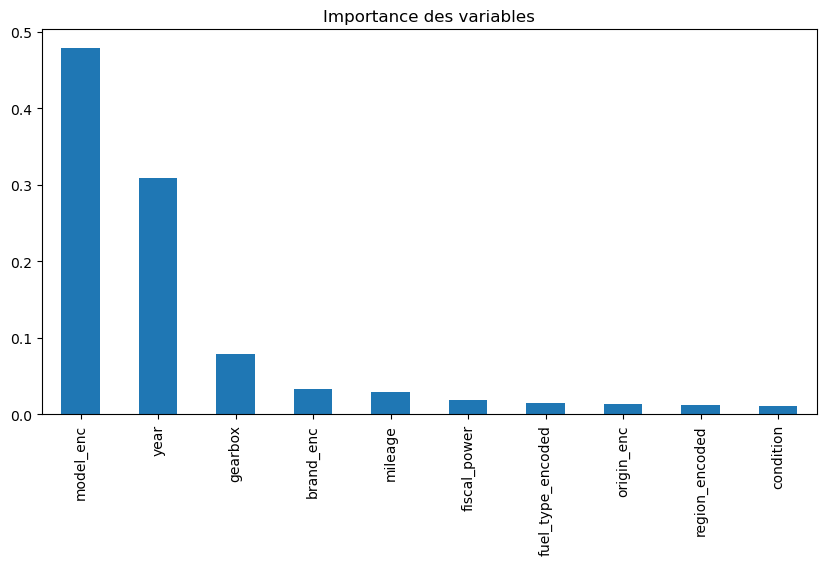


📊 Résultats pour CatBoost
MAE : 11488.729774349013
RMSE: 16485.295607899126
R²  : 0.9366051229509406

📊 Résultats pour CatBoost
MAE : 14635.416999578074
RMSE: 22633.45712862238
R²  : 0.8828454401596265


['modele_cat.pkl']

In [80]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Entraînement du modèle
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

# Importance des features
importances = pd.Series(tree.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title("Importance des variables")
plt.show()
important_features = importances[importances > 0.03].index.tolist()
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]


cat.fit(X_train, y_train)
y_train_pred = cat.predict(X_train)
y_test_pred = cat.predict(X_test)
print_metrics(y_train, y_train_pred, "CatBoost")
print_metrics(y_test, y_test_pred, "CatBoost")
# Sauvegarde du modèle dans un fichier .joblib
joblib.dump(cat, 'modele_cat.pkl') 


In [81]:
colonnes_importantes = [
    'gearbox',
    'brand_enc',
    'fuel_type_encoded',
    'model_enc',
    'year',
]

X_train = X_train[colonnes_importantes]
X_test = X_test[colonnes_importantes]

In [82]:
from sklearn.ensemble import HistGradientBoostingRegressor

models = {
    "HistGBR": HistGradientBoostingRegressor(max_iter=400, max_depth=45, random_state=42),
    # "XGBoost": XGBRegressor(n_estimators=150, max_depth=25, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, max_depth=25, random_state=42, verbose=-1),
    #"CatBoost": CatBoostRegressor(iterations=200, depth=10, verbose=0, random_state=42)
}

for name, model in models.items():
    print(f"\n🔹 Résultats pour le modèle: {name}")
    model.fit(X_train, y_train)
    print_metrics(y_train, model.predict(X_train), f"{name} - Train")
    print_metrics(y_test, model.predict(X_test), f"{name} - Test")
# 2. Sauvegarde du modèle dans un fichier .joblib



🔹 Résultats pour le modèle: HistGBR

📊 Résultats pour HistGBR - Train
MAE : 11941.751763676717
RMSE: 17985.06280028239
R²  : 0.9245455942972922

📊 Résultats pour HistGBR - Test
MAE : 14862.171357422856
RMSE: 22928.108895798276
R²  : 0.8797752512403404

🔹 Résultats pour le modèle: LightGBM

📊 Résultats pour LightGBM - Train
MAE : 12927.33103551251
RMSE: 19528.099703594602
R²  : 0.9110428924921632

📊 Résultats pour LightGBM - Test
MAE : 15039.670096128919
RMSE: 23166.469162640227
R²  : 0.877262548499043
